In [1]:
#made in Google Colab
import re
import nltk
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

nltk.download('stopwords')
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
nltk.download('punkt')
!pip install torchsummaryX
from nltk import word_tokenize
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from torchsummaryX import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
PATH = '/content/drive/MyDrive/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
entire_df = pd.read_csv(PATH + "TheSocialDilemma.csv")

print(entire_df.shape)


(20068, 14)


In [5]:
#Makes sentiment binomial with neutral considered negative as well
df = entire_df[["text", "Sentiment"]]
df['Sentiment'] = df['Sentiment'].replace(['Negative','Neutral', 'Positive'],
                                                          [0, 0, 1])
df.columns = ['text', 'label']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 20')

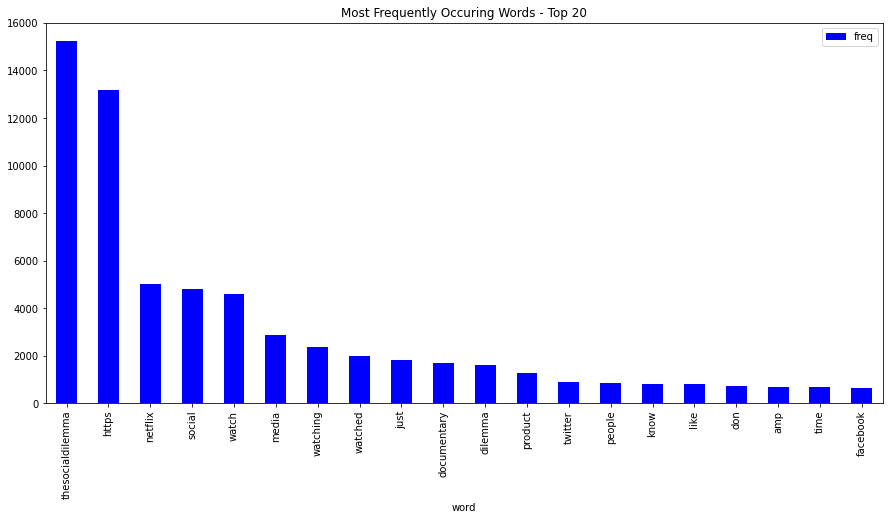

In [6]:
#get top 20 most frequently occurring words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 20")

In [7]:
#Tokenizes text
tokenized_text = df['text'].apply(lambda x: x.split()) 
#Embedding through gensim word to vector library
model_w2v = gensim.models.Word2Vec(
            tokenized_text, window=5, min_count=2,
            sg = 1, hs = 0,negative = 10, workers= 2,
            seed = 34)
#vocabulary
model_w2v.train(tokenized_text, total_examples= len(df['text']), epochs=20)

(4361290, 6399320)

In [8]:
model_w2v.wv.most_similar("hate")

[('reenactments', 0.6606390476226807),
 ('urges', 0.6169399619102478),
 (',who', 0.6023297309875488),
 ('mos…', 0.5975050330162048),
 ('whn', 0.5967164039611816),
 ('chose', 0.5935315489768982),
 ('smoking', 0.5919181704521179),
 ('items', 0.5888330340385437),
 ('block', 0.5855193138122559),
 ('apologize', 0.5821371078491211)]

In [9]:
#appends a unique text number at the end of the sentence
def append_label (text_):
    output = []
    for i, s in zip(text_.index, text_):
        output.append(TaggedDocument(s, ["text_" + str(i)]))
    return output

# labelling all the texts here
labeled_texts = append_label (tokenized_text)

labeled_texts[:1]

[TaggedDocument(words=['@musicmadmarc', '@SocialDilemma_', '@netflix', '@Facebook', "I'm", 'also', 'reminded', 'of', 'the', 'very', 'poignant', 'quote', 'by', 'French', 'philosopher…', 'https://t.co/CA52aepW6K'], tags=['text_0'])]

In [10]:
df_corpus = []
#prepocessing data by removing poor features
for i in range(0, len(df)):
    process = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    process = process.lower()
    
    
    process = re.sub('\[.*?\]', '', process)
    process = re.sub('https?://\S+|www\.\S+', '', process)
    process = re.sub('\n', '', process)
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    process = emoji_pattern.sub(r'', process)
    
    
    process = process.split()
    ps = PorterStemmer()

    # lemmetization/stemming
    stop_words = stopwords.words('english')
    # also removing #thesocialdilemma because it comes too many times
    stop_words.extend(["thesocialdilemma"])
    process = [ps.stem(word) for word in process if not word in set(stop_words)]

    # joining them back with space
    process = ' '.join(process)
    df_corpus.append(process)

In [11]:
#converts everything to vector of token counts that builds a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
cv = CountVectorizer(max_features = 2500)

y = df["label"]
X_train, X_valid, y_train, y_valid = train_test_split(df_corpus, y, test_size = 0.25, random_state = 4211)

X_train = cv.fit_transform(X_train)
X_valid = cv.transform(X_valid)

In [12]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(15051, 2500)
(5017, 2500)
(15051,)
(5017,)


In [13]:
sc = StandardScaler(with_mean=False)

X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [14]:
#sets up arrays to store best accuracies for each model
best_train_acc_mo = []
best_valid_acc_mo = []

In [15]:
#class to train for several models
def basic_models (model_type, X_train, X_test, y_train, y_test):
    if model_type == 'XGB':
        model = XGBClassifier(use_label_encoder=False)
    
    elif model_type == 'DecisionTree':
        model = DecisionTreeClassifier()
        
    elif model_type == 'RandomForest':
        model = RandomForestClassifier()
    
    elif model_type == 'SupportMachineVector':
        model = SVC()
        
    model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)
    #visual output showing what has happened to model    
    # confusion matrix
    plot_confusion_matrix(model, X_test, y_test.values.ravel())

    print("Training Accuracy [{}]: ".format(model_type), model.score(X_train, y_train.values.ravel()))
    print("Validation Accuracy [{}]:".format(model_type), model.score(X_test, y_test.values.ravel()))
    best_train_acc_mo.append(model.score(X_train, y_train.values.ravel()))
    best_valid_acc_mo.append(model.score(X_test, y_test.values.ravel()))
    # calculating the f1 score for the validation set
    print("f1 score [{}]:".format(model_type), f1_score(y_test, y_pred, average='weighted'))

Training Accuracy [XGB]:  0.812637034084114
Validation Accuracy [XGB]: 0.8002790512258322
f1 score [XGB]: 0.7977730804891426


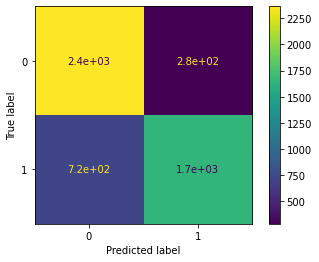

In [16]:
basic_models('XGB', X_train, X_valid, y_train, y_valid)

Training Accuracy [DecisionTree]:  0.9991362700152814
Validation Accuracy [DecisionTree]: 0.8568865856089296
f1 score [DecisionTree]: 0.8568801287299453


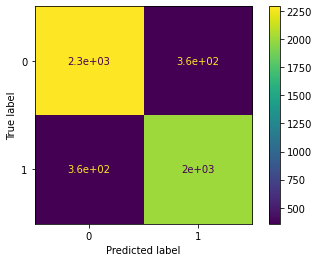

In [17]:
basic_models('DecisionTree', X_train, X_valid, y_train, y_valid)

Training Accuracy [RandomForest]:  0.9991362700152814
Validation Accuracy [RandomForest]: 0.8664540562088898
f1 score [RandomForest]: 0.8664764441075761


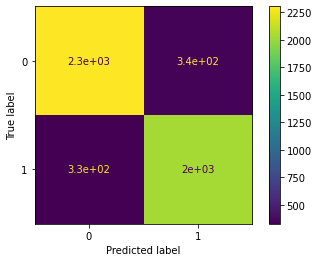

In [18]:
basic_models('RandomForest', X_train, X_valid, y_train, y_valid)

Training Accuracy [SupportMachineVector]:  0.9596704537904458
Validation Accuracy [SupportMachineVector]: 0.8289814630257126
f1 score [SupportMachineVector]: 0.8289658117257686


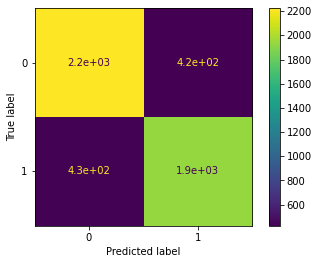

In [19]:
basic_models('SupportMachineVector', X_train, X_valid, y_train, y_valid)

In [20]:
entire_df = pd.read_csv(PATH + "TheSocialDilemma.csv")

print(entire_df.shape)

(20068, 14)


In [21]:
#Remaking data set to have an equal number of test cases
df = entire_df[["Sentiment", "text"]]
df['Sentiment'] = df['Sentiment'].replace(['Negative','Neutral', 'Positive'],
                                                          [0, 0, 1])
df.columns = ['label', 'text']
mask = df['label'] == 1
df1 = df[mask]
df2 = df[~mask]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
#Sets up train and valid and makes them CV for iterator bucket use
traindf1, validdf1= train_test_split(df1, test_size=0.26374434984, random_state=4211)
traindf2, validdf2= train_test_split(df2, test_size=0.23770724775, random_state=4211)
frames2 = [traindf2, traindf1]
train = pd.concat(frames2)
print (train)
frames1 = [validdf2, validdf1]
valid = pd.concat(frames1)
print (valid)
train.to_csv('/content/train.csv', index=False)
valid.to_csv('/content/valid.csv', index=False)


       label                                               text
16803      0  Everyone needs to take an hour and 30 minutes ...
11293      0  If you haven't watched #TheSocialDilemma yet, ...
18038      0  Sometimes I surprise my #YouTube #AI voodoo do...
9115       0                  #TheSocialDilemma is a must watch
876        0  Just watched #thesocialdilemma wow that movie ...
...      ...                                                ...
7146       1  It's interesting that they brought up bicycles...
16156      1  @joerogan would love to see a conversation on ...
2393       1  I started watching #TheSocialDilemma and have ...
2937       1  #TheSocialDilemma on @netflix has literally ma...
442        1  #TheSocialDilemma is a must see for sure. Thin...

[15048 rows x 2 columns]
       label                                               text
16801      0  “If you’re not paying for the product, then yo...
13071      0  @naval Need some sort of regulation. Also, an ...
2376       0  

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
#sets fields, datasets and bucket iterators of train and valid
txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True) # "i like the moive" -> "i", "like", "the", "movie"
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float) #0, 1
train = TabularDataset(path = '/content/train.csv', format='CSV', fields = [('label', label_field), ('text', txt_field)], skip_header = True)
valid = TabularDataset(path = '/content/valid.csv', format='CSV', fields = [('label', label_field), ('text', txt_field)], skip_header = True)
trainerator, validerator = BucketIterator.splits((train, valid), batch_size=64, device=device,
                                               sort_key=lambda x: len(x.text), sort_within_batch=True)

#Builds vocabulary and checks OOV 
txt_field.build_vocab(valid, min_freq=1)
words_num = len(txt_field.vocab)
txt_field.build_vocab(valid, min_freq=2)
vocab_num = len(txt_field.vocab)
print("Valid oov:"+ str(words_num - vocab_num))

txt_field.build_vocab(train, min_freq=1)
num_words = len(txt_field.vocab)
txt_field.build_vocab(train, min_freq=2)
num_vocab = len(txt_field.vocab)
print("Train oov:" + str(num_words - num_vocab))
#padding for method 2
padding_index = txt_field.vocab.stoi[txt_field.pad_token]


Valid oov:8507
Train oov:20213


In [25]:
#Baseline model of RNN
class RNN_0(nn.Module):
    def __init__(self):
        super(RNN_0, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) #embedding layer of dimensionality 50
        self.rnn = nn.RNN(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True
        )#RNN layer made RNN cell with hidden dimensionality 64
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

In [26]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    print(f'Model loaded from {save_path}')

#training
def TRAIN(model, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss, device, save_name,train_lossep, valid_lossep, valid_accep, best_valid_acc_mo, best_train_acc_mo):
    
    if val_loss==None:
        best_val_acc = 0  
    else: 
        best_val_acc=valid_acc
        print('Resume training')
    best_train_acc = 0
    model.to(device)


    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_num = 0
        for i, ((labels, (text, text_len)), _) in enumerate(train_loader):

            text = text.to(device)
            text_len = text_len.to(device)
            labels = labels.to(device)

            '''Training of the model'''
            # Forward pass
            output = model(text, text_len)
            loss = criterion(output, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = (output > 0.5).float()
            running_corrects += torch.sum(pred == labels)
            running_num += len(labels)
        train_loss = running_loss / running_num
        train_acc = running_corrects/ running_num
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            running_num = 0
            for ((labels, (text, text_len)), _) in valid_loader:

                text = text.to(device)
                text_len = text_len.to(device)
                labels = labels.to(device)

                # Forward pass
                output = model(text, text_len)
                loss = criterion(output, labels)

                running_loss += loss.item()
                pred = (output > 0.5).float()
                running_corrects += torch.sum(pred == labels)
                running_num += len(labels)

            val_loss = running_loss / running_num
            valid_acc = running_corrects / running_num
            valid_lossep.append(val_loss)
            train_lossep.append(train_loss)
            valid_accep.append(valid_acc)
            print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f} ' 
                  .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, valid_acc))
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                best_train_acc = train_acc
                save_checkpoint(save_name, model, optimizer, best_val_acc)
    best_train_acc_mo.append(best_train_acc)
    best_valid_acc_mo.append(best_val_acc)
        

    print('Finished Training')

In [27]:
#sets up array for storage
num_epoch_arr = []
train_lossep = []
valid_lossep = []
valid_accep = []
#sets up model, save name, criterion, optimizer 
model=RNN_0()
n_epochs = 15
for i in range(n_epochs):
    num_epoch_arr.append((i+1))
trainerator, validerator
val_loss = None
save_name = 'rnn_model'
criterion = nn.BCELoss()
optimizer = Adam(model.parameters())
#start training
TRAIN(model, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name,train_lossep, valid_lossep, valid_accep, best_valid_acc_mo, best_train_acc_mo) 

Epoch [1/15], Train Loss: 0.0107, Train Acc: 0.5490, Valid Loss: 0.0102, Valid Acc: 0.6351 
Model saved to rnn_model
Epoch [2/15], Train Loss: 0.0100, Train Acc: 0.6465, Valid Loss: 0.0098, Valid Acc: 0.6793 
Model saved to rnn_model
Epoch [3/15], Train Loss: 0.0087, Train Acc: 0.7334, Valid Loss: 0.0089, Valid Acc: 0.7231 
Model saved to rnn_model
Epoch [4/15], Train Loss: 0.0076, Train Acc: 0.7876, Valid Loss: 0.0079, Valid Acc: 0.7795 
Model saved to rnn_model
Epoch [5/15], Train Loss: 0.0070, Train Acc: 0.8142, Valid Loss: 0.0075, Valid Acc: 0.8042 
Model saved to rnn_model
Epoch [6/15], Train Loss: 0.0062, Train Acc: 0.8482, Valid Loss: 0.0070, Valid Acc: 0.8207 
Model saved to rnn_model
Epoch [7/15], Train Loss: 0.0055, Train Acc: 0.8689, Valid Loss: 0.0067, Valid Acc: 0.8331 
Model saved to rnn_model
Epoch [8/15], Train Loss: 0.0048, Train Acc: 0.8888, Valid Loss: 0.0065, Valid Acc: 0.8398 
Model saved to rnn_model
Epoch [9/15], Train Loss: 0.0043, Train Acc: 0.9052, Valid Loss:

In [28]:
#RNN model 1 using GRU
class RNN_1(nn.Module):
    def __init__(self):
        super(RNN_1, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) 
        self.rnn = nn.GRU(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

In [29]:
model1=RNN_1()
n_epochs = 15
train_lossep1 = []
valid_lossep1 = []
valid_accep1 = []
val_loss = None
save_name1 = 'rnn_model1'
criterion = nn.BCELoss()
optimizer = Adam(model1.parameters())
#start training
TRAIN(model1, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name1,train_lossep1, valid_lossep1, valid_accep1, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0101, Train Acc: 0.6091, Valid Loss: 0.0086, Valid Acc: 0.7315 
Model saved to rnn_model1
Epoch [2/15], Train Loss: 0.0075, Train Acc: 0.7899, Valid Loss: 0.0069, Valid Acc: 0.8209 
Model saved to rnn_model1
Epoch [3/15], Train Loss: 0.0059, Train Acc: 0.8505, Valid Loss: 0.0065, Valid Acc: 0.8384 
Model saved to rnn_model1
Epoch [4/15], Train Loss: 0.0049, Train Acc: 0.8775, Valid Loss: 0.0058, Valid Acc: 0.8606 
Model saved to rnn_model1
Epoch [5/15], Train Loss: 0.0042, Train Acc: 0.8989, Valid Loss: 0.0054, Valid Acc: 0.8671 
Model saved to rnn_model1
Epoch [6/15], Train Loss: 0.0035, Train Acc: 0.9176, Valid Loss: 0.0054, Valid Acc: 0.8721 
Model saved to rnn_model1
Epoch [7/15], Train Loss: 0.0029, Train Acc: 0.9340, Valid Loss: 0.0052, Valid Acc: 0.8767 
Model saved to rnn_model1
Epoch [8/15], Train Loss: 0.0024, Train Acc: 0.9486, Valid Loss: 0.0052, Valid Acc: 0.8888 
Model saved to rnn_model1
Epoch [9/15], Train Loss: 0.0020, Train Acc: 0.9584, Val

In [30]:
#RNN model 2 using LSTM

class RNN_2(nn.Module):
    def __init__(self):
        super(RNN_2, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) 
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

In [31]:
model2=RNN_2()
n_epochs = 15
train_lossep2 = []
valid_lossep2 = []
valid_accep2 = []
val_loss = None
save_name2 = 'rnn_model2'
criterion = nn.BCELoss()
optimizer = Adam(model2.parameters())
#start training
TRAIN(model2, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name2, train_lossep2, valid_lossep2, valid_accep2, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0099, Train Acc: 0.6394, Valid Loss: 0.0087, Valid Acc: 0.7339 
Model saved to rnn_model2
Epoch [2/15], Train Loss: 0.0078, Train Acc: 0.7784, Valid Loss: 0.0074, Valid Acc: 0.7942 
Model saved to rnn_model2
Epoch [3/15], Train Loss: 0.0063, Train Acc: 0.8345, Valid Loss: 0.0064, Valid Acc: 0.8279 
Model saved to rnn_model2
Epoch [4/15], Train Loss: 0.0052, Train Acc: 0.8717, Valid Loss: 0.0058, Valid Acc: 0.8578 
Model saved to rnn_model2
Epoch [5/15], Train Loss: 0.0044, Train Acc: 0.8957, Valid Loss: 0.0058, Valid Acc: 0.8548 
Epoch [6/15], Train Loss: 0.0038, Train Acc: 0.9125, Valid Loss: 0.0058, Valid Acc: 0.8616 
Model saved to rnn_model2
Epoch [7/15], Train Loss: 0.0032, Train Acc: 0.9258, Valid Loss: 0.0054, Valid Acc: 0.8729 
Model saved to rnn_model2
Epoch [8/15], Train Loss: 0.0028, Train Acc: 0.9371, Valid Loss: 0.0056, Valid Acc: 0.8735 
Model saved to rnn_model2
Epoch [9/15], Train Loss: 0.0023, Train Acc: 0.9502, Valid Loss: 0.0060, Valid Acc

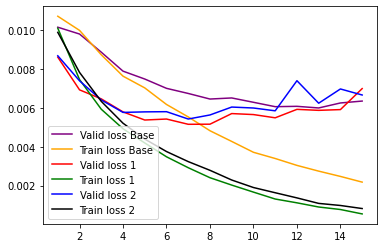

In [32]:
plt.plot(num_epoch_arr, valid_lossep, c='purple', label="Valid loss Base")
plt.plot(num_epoch_arr, train_lossep, c='orange', label="Train loss Base")
plt.plot(num_epoch_arr, valid_lossep1, c='red', label="Valid loss 1")
plt.plot(num_epoch_arr, train_lossep1, c='green', label="Train loss 1")
plt.plot(num_epoch_arr, valid_lossep2, c='blue', label="Valid loss 2")
plt.plot(num_epoch_arr, train_lossep2, c='black', label="Train loss 2")
plt.legend()
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.dpi"] = 150
plt.show()      
#Plot between training of base, model 1, model 2

In [33]:
#RNN model 3 using Bidirection LSTM
class RNN_3(nn.Module):
    def __init__(self):
        super(RNN_3, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) 
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
                bidirectional = True
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(128, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x

In [34]:
model3=RNN_3()
n_epochs = 15
train_lossep3 = []
valid_lossep3 = []
valid_accep3 = []
val_loss = None
save_name3 = 'rnn_model3'
criterion = nn.BCELoss()
optimizer = Adam(model3.parameters())
#start training
TRAIN(model3, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name3, train_lossep3, valid_lossep3, valid_accep3, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0098, Train Acc: 0.6439, Valid Loss: 0.0088, Valid Acc: 0.7209 
Model saved to rnn_model3
Epoch [2/15], Train Loss: 0.0079, Train Acc: 0.7683, Valid Loss: 0.0075, Valid Acc: 0.7875 
Model saved to rnn_model3
Epoch [3/15], Train Loss: 0.0064, Train Acc: 0.8339, Valid Loss: 0.0067, Valid Acc: 0.8181 
Model saved to rnn_model3
Epoch [4/15], Train Loss: 0.0053, Train Acc: 0.8699, Valid Loss: 0.0058, Valid Acc: 0.8530 
Model saved to rnn_model3
Epoch [5/15], Train Loss: 0.0044, Train Acc: 0.8949, Valid Loss: 0.0057, Valid Acc: 0.8606 
Model saved to rnn_model3
Epoch [6/15], Train Loss: 0.0037, Train Acc: 0.9121, Valid Loss: 0.0054, Valid Acc: 0.8701 
Model saved to rnn_model3
Epoch [7/15], Train Loss: 0.0032, Train Acc: 0.9273, Valid Loss: 0.0053, Valid Acc: 0.8769 
Model saved to rnn_model3
Epoch [8/15], Train Loss: 0.0027, Train Acc: 0.9388, Valid Loss: 0.0055, Valid Acc: 0.8789 
Model saved to rnn_model3
Epoch [9/15], Train Loss: 0.0023, Train Acc: 0.9517, Val

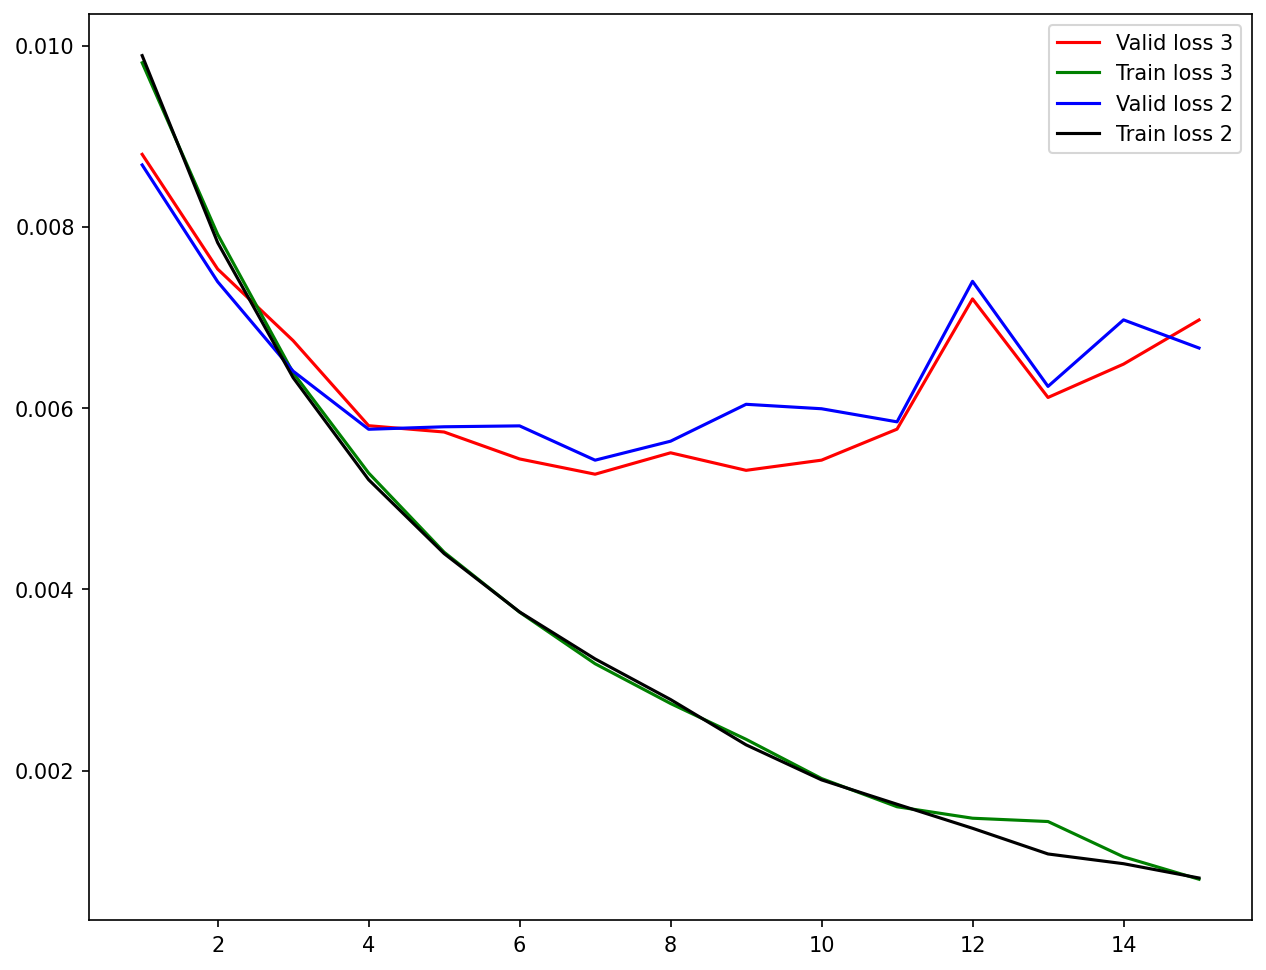

In [35]:
plt.plot(num_epoch_arr, valid_lossep3, c='red', label="Valid loss 3")
plt.plot(num_epoch_arr, train_lossep3, c='green', label="Train loss 3")
plt.plot(num_epoch_arr, valid_lossep2, c='blue', label="Valid loss 2")
plt.plot(num_epoch_arr, train_lossep2, c='black', label="Train loss 2")
plt.legend()
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.dpi"] = 150
plt.show()
#graph between model 2 and model 3

In [36]:
from torchtext.vocab import GloVe
embedding_glove = GloVe(name='6B', dim=50)


.vector_cache/glove.6B.zip: 862MB [02:48, 5.12MB/s]                           
100%|█████████▉| 399622/400000 [00:13<00:00, 30543.45it/s]

In [37]:
#building glove vocabulary
txt_field.build_vocab(train, min_freq=2, vectors=GloVe(name='6B', dim=50))
num_vocab1 = len(txt_field.vocab)

padding_index1 = txt_field.vocab.stoi[txt_field.pad_token]

In [38]:
#model 4 with pretrained glove embedding thats not fine tuned
class RNN_4(nn.Module):
    def __init__(self):
        super(RNN_4, self).__init__()
        weights = txt_field.vocab.vectors
        self.emb = nn.Embedding.from_pretrained(embeddings=weights, freeze=True ,padding_idx = padding_index1)   
        self.emb.weight.data = txt_field.vocab.vectors
        #pretrains
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x

In [39]:
model4=RNN_4()
n_epochs = 15
train_lossep4 = []
valid_lossep4 = []
valid_accep4 = []
val_loss = None
save_name4 = 'rnn_model4'
criterion = nn.BCELoss()
optimizer = Adam(model4.parameters())
#start training
TRAIN(model4, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name4, train_lossep4, valid_lossep4, valid_accep4, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0098, Train Acc: 0.6522, Valid Loss: 0.0085, Valid Acc: 0.7464 
Model saved to rnn_model4
Epoch [2/15], Train Loss: 0.0084, Train Acc: 0.7482, Valid Loss: 0.0082, Valid Acc: 0.7604 
Model saved to rnn_model4


100%|█████████▉| 399622/400000 [00:29<00:00, 30543.45it/s]

Epoch [3/15], Train Loss: 0.0079, Train Acc: 0.7675, Valid Loss: 0.0076, Valid Acc: 0.7799 
Model saved to rnn_model4
Epoch [4/15], Train Loss: 0.0075, Train Acc: 0.7840, Valid Loss: 0.0079, Valid Acc: 0.7504 
Epoch [5/15], Train Loss: 0.0071, Train Acc: 0.7961, Valid Loss: 0.0068, Valid Acc: 0.8086 
Model saved to rnn_model4
Epoch [6/15], Train Loss: 0.0067, Train Acc: 0.8057, Valid Loss: 0.0069, Valid Acc: 0.8016 
Epoch [7/15], Train Loss: 0.0064, Train Acc: 0.8202, Valid Loss: 0.0066, Valid Acc: 0.8183 
Model saved to rnn_model4
Epoch [8/15], Train Loss: 0.0061, Train Acc: 0.8293, Valid Loss: 0.0063, Valid Acc: 0.8209 
Model saved to rnn_model4
Epoch [9/15], Train Loss: 0.0058, Train Acc: 0.8403, Valid Loss: 0.0066, Valid Acc: 0.8285 
Model saved to rnn_model4
Epoch [10/15], Train Loss: 0.0056, Train Acc: 0.8437, Valid Loss: 0.0062, Valid Acc: 0.8307 
Model saved to rnn_model4
Epoch [11/15], Train Loss: 0.0053, Train Acc: 0.8524, Valid Loss: 0.0061, Valid Acc: 0.8388 
Model saved to

In [40]:
#model 5 with pretrained glove embedding that is fine tuned
class RNN_5(nn.Module):
    def __init__(self):
        super(RNN_5, self).__init__()
        weights = txt_field.vocab.vectors
        self.emb = nn.Embedding.from_pretrained(embeddings=weights, freeze=False ,padding_idx = padding_index1)        
        self.emb.weight.data = txt_field.vocab.vectors 
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x

In [41]:
model5=RNN_5()
n_epochs = 15
train_lossep5 = []
valid_lossep5 = []
valid_accep5 = []
val_loss = None
save_name5 = 'rnn_model5'
criterion = nn.BCELoss()
optimizer = Adam(model5.parameters())
#start training
TRAIN(model5, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name5, train_lossep5, valid_lossep5, valid_accep5, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0095, Train Acc: 0.6684, Valid Loss: 0.0074, Valid Acc: 0.8032 
Model saved to rnn_model5
Epoch [2/15], Train Loss: 0.0066, Train Acc: 0.8326, Valid Loss: 0.0055, Valid Acc: 0.8635 
Model saved to rnn_model5
Epoch [3/15], Train Loss: 0.0047, Train Acc: 0.8878, Valid Loss: 0.0046, Valid Acc: 0.8900 
Model saved to rnn_model5
Epoch [4/15], Train Loss: 0.0036, Train Acc: 0.9187, Valid Loss: 0.0044, Valid Acc: 0.9014 
Model saved to rnn_model5
Epoch [5/15], Train Loss: 0.0028, Train Acc: 0.9405, Valid Loss: 0.0037, Valid Acc: 0.9147 
Model saved to rnn_model5
Epoch [6/15], Train Loss: 0.0021, Train Acc: 0.9561, Valid Loss: 0.0036, Valid Acc: 0.9307 
Model saved to rnn_model5
Epoch [7/15], Train Loss: 0.0016, Train Acc: 0.9682, Valid Loss: 0.0035, Valid Acc: 0.9279 
Epoch [8/15], Train Loss: 0.0012, Train Acc: 0.9749, Valid Loss: 0.0037, Valid Acc: 0.9343 
Model saved to rnn_model5
Epoch [9/15], Train Loss: 0.0011, Train Acc: 0.9815, Valid Loss: 0.0038, Valid Acc

In [42]:
#model 6 with pretrained random vector embedding 
class RNN_6(nn.Module):
    def __init__(self):
        super(RNN_6, self).__init__()
        weights = torch.FloatTensor(num_vocab1, 50)
        self.emb = nn.Embedding.from_pretrained(embeddings=weights, freeze=True ,padding_idx = padding_index1)         
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
        )
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x

In [43]:
model6=RNN_6()
n_epochs = 15
train_lossep6 = []
valid_lossep6 = []
valid_accep6 = []
val_loss = None
save_name6 = 'rnn_model6'
criterion = nn.BCELoss()
optimizer = Adam(model6.parameters())
#start training
TRAIN(model6, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name6, train_lossep6, valid_lossep6, valid_accep6, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0103, Train Acc: 0.6019, Valid Loss: 0.0096, Valid Acc: 0.6715 
Model saved to rnn_model6
Epoch [2/15], Train Loss: 0.0092, Train Acc: 0.6893, Valid Loss: 0.0088, Valid Acc: 0.7179 
Model saved to rnn_model6
Epoch [3/15], Train Loss: 0.0086, Train Acc: 0.7238, Valid Loss: 0.0084, Valid Acc: 0.7420 
Model saved to rnn_model6
Epoch [4/15], Train Loss: 0.0081, Train Acc: 0.7525, Valid Loss: 0.0083, Valid Acc: 0.7414 
Epoch [5/15], Train Loss: 0.0076, Train Acc: 0.7707, Valid Loss: 0.0080, Valid Acc: 0.7616 
Model saved to rnn_model6
Epoch [6/15], Train Loss: 0.0072, Train Acc: 0.7882, Valid Loss: 0.0078, Valid Acc: 0.7729 
Model saved to rnn_model6
Epoch [7/15], Train Loss: 0.0070, Train Acc: 0.8013, Valid Loss: 0.0079, Valid Acc: 0.7476 
Epoch [8/15], Train Loss: 0.0066, Train Acc: 0.8163, Valid Loss: 0.0076, Valid Acc: 0.7853 
Model saved to rnn_model6
Epoch [9/15], Train Loss: 0.0062, Train Acc: 0.8289, Valid Loss: 0.0075, Valid Acc: 0.7821 
Epoch [10/15], T

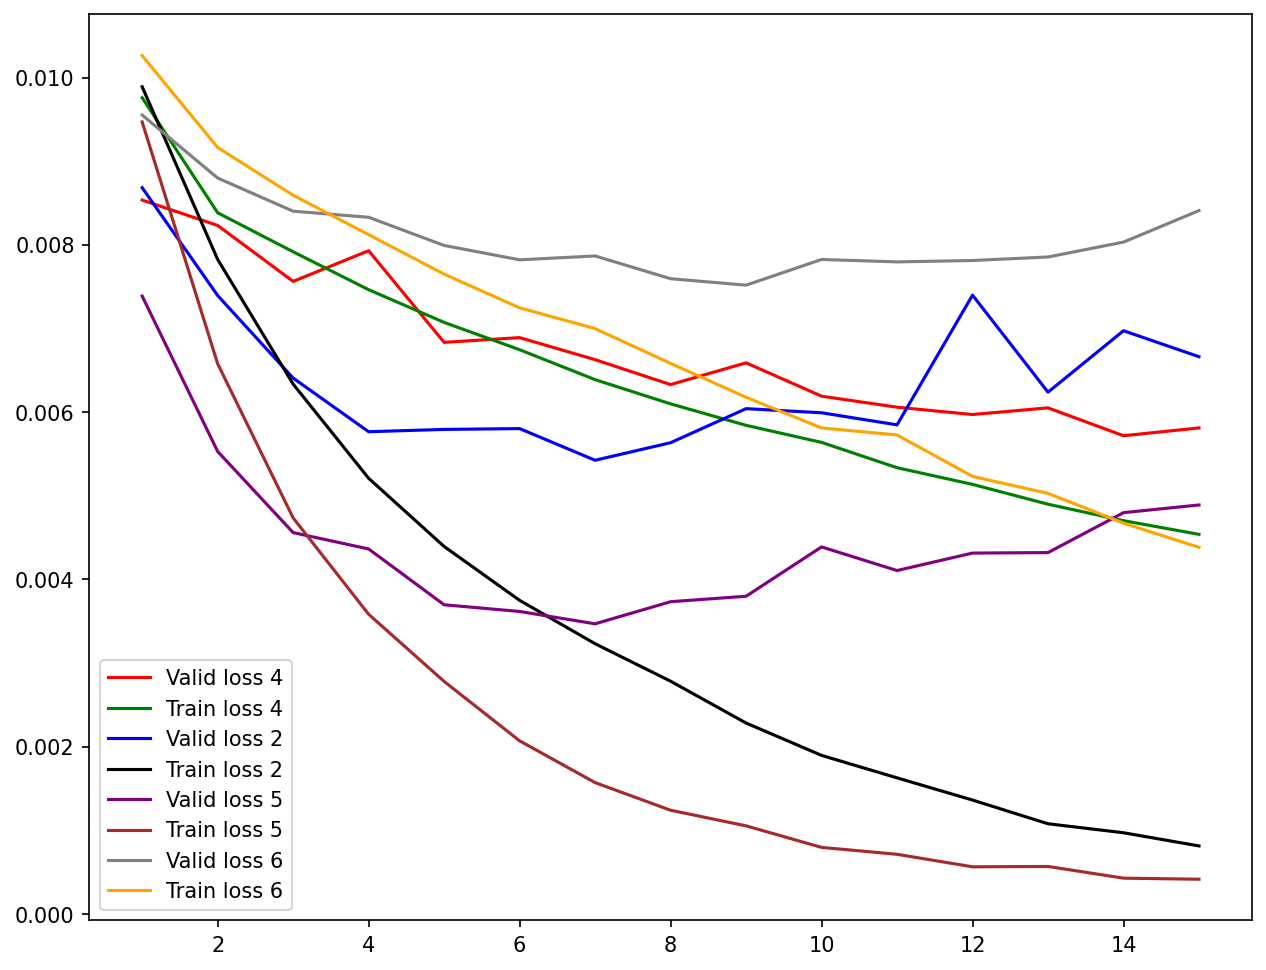

In [44]:
plt.plot(num_epoch_arr, valid_lossep4, c='red', label="Valid loss 4")
plt.plot(num_epoch_arr, train_lossep4, c='green', label="Train loss 4")
plt.plot(num_epoch_arr, valid_lossep2, c='blue', label="Valid loss 2")
plt.plot(num_epoch_arr, train_lossep2, c='black', label="Train loss 2")
plt.plot(num_epoch_arr, valid_lossep5, c='purple', label="Valid loss 5")
plt.plot(num_epoch_arr, train_lossep5, c='brown', label="Train loss 5")
plt.plot(num_epoch_arr, valid_lossep6, c='gray', label="Valid loss 6")
plt.plot(num_epoch_arr, train_lossep6, c='orange', label="Train loss 6")
plt.legend()
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.dpi"] = 150
plt.show()
#plot bween models 2,4,5,6

In [45]:
txt_field.build_vocab(train, min_freq=2)
num_vocab = len(txt_field.vocab)

padding_index = txt_field.vocab.stoi[txt_field.pad_token]

In [46]:
#model 7 that uses Xavier initialization
class RNN_7(nn.Module):
    def __init__(self):
        super(RNN_7, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) 
        self.emb.weight = nn.init.xavier_normal_(self.emb.weight)
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True
        )
        self.rnn.weight_hh_l0=nn.init.xavier_normal_(self.rnn.weight_hh_l0)
        self.rnn.weight_ih_l0=nn.init.xavier_normal_(self.rnn.weight_ih_l0)
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

In [47]:
model7=RNN_7()
n_epochs = 15
train_lossep7 = []
valid_lossep7 = []
valid_accep7 = []
val_loss = None
save_name7 = 'rnn_model7'
criterion = nn.BCELoss()
optimizer = Adam(model7.parameters())
#start training
TRAIN(model7, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name7, train_lossep7, valid_lossep7, valid_accep7, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0085, Train Acc: 0.6940, Valid Loss: 0.0057, Valid Acc: 0.8705 
Model saved to rnn_model7
Epoch [2/15], Train Loss: 0.0040, Train Acc: 0.9089, Valid Loss: 0.0050, Valid Acc: 0.8737 
Model saved to rnn_model7
Epoch [3/15], Train Loss: 0.0027, Train Acc: 0.9400, Valid Loss: 0.0044, Valid Acc: 0.9060 
Model saved to rnn_model7
Epoch [4/15], Train Loss: 0.0020, Train Acc: 0.9602, Valid Loss: 0.0047, Valid Acc: 0.8952 
Epoch [5/15], Train Loss: 0.0016, Train Acc: 0.9679, Valid Loss: 0.0043, Valid Acc: 0.9157 
Model saved to rnn_model7
Epoch [6/15], Train Loss: 0.0012, Train Acc: 0.9775, Valid Loss: 0.0043, Valid Acc: 0.9175 
Model saved to rnn_model7
Epoch [7/15], Train Loss: 0.0011, Train Acc: 0.9806, Valid Loss: 0.0045, Valid Acc: 0.9169 
Epoch [8/15], Train Loss: 0.0009, Train Acc: 0.9837, Valid Loss: 0.0043, Valid Acc: 0.9227 
Model saved to rnn_model7
Epoch [9/15], Train Loss: 0.0007, Train Acc: 0.9876, Valid Loss: 0.0047, Valid Acc: 0.9253 
Model saved to r

In [48]:
#model 8 that uses Kaiming initialization
class RNN_8(nn.Module):
    def __init__(self):
        super(RNN_8, self).__init__()
        self.emb = nn.Embedding(num_vocab, 50, padding_index) 
        self.emb.weight = nn.init.kaiming_normal_(self.emb.weight)
        self.rnn = nn.LSTM(
                input_size=50,
                hidden_size=64,
                num_layers=1,
                batch_first=True
        )
        self.drpout = nn.Dropout(p=0.1)
        self.rnn.weight_hh_l0=nn.init.kaiming_normal_(self.rnn.weight_hh_l0)
        self.rnn.weight_ih_l0=nn.init.kaiming_normal_(self.rnn.weight_ih_l0)
        self.drpout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(64, 1)
        self.fc.weight = nn.init.kaiming_normal_(self.fc.weight)
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        # method 2, pack the input sequence, more computationally efficient
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs_want = outputs[range(len(outputs)), sent_len - 1]
        x = self.drpout(outputs_want)
        x = self.fc(x)
        x = torch.squeeze(x,1)
        x = torch.sigmoid(x)
        return x
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 

In [49]:
model8=RNN_8()
n_epochs = 15
train_lossep8 = []
valid_lossep8 = []
valid_accep8 = []
val_loss = None
save_name8 = 'rnn_model8'
criterion = nn.BCELoss()
optimizer = Adam(model8.parameters())
#start training
TRAIN(model8, trainerator, validerator,  n_epochs, criterion, optimizer, val_loss, device, save_name8, train_lossep8, valid_lossep8, valid_accep8, best_valid_acc_mo, best_train_acc_mo)

Epoch [1/15], Train Loss: 0.0088, Train Acc: 0.7077, Valid Loss: 0.0069, Valid Acc: 0.8199 
Model saved to rnn_model8
Epoch [2/15], Train Loss: 0.0050, Train Acc: 0.8814, Valid Loss: 0.0050, Valid Acc: 0.8757 
Model saved to rnn_model8
Epoch [3/15], Train Loss: 0.0035, Train Acc: 0.9223, Valid Loss: 0.0046, Valid Acc: 0.8936 
Model saved to rnn_model8
Epoch [4/15], Train Loss: 0.0025, Train Acc: 0.9467, Valid Loss: 0.0046, Valid Acc: 0.8976 
Model saved to rnn_model8
Epoch [5/15], Train Loss: 0.0019, Train Acc: 0.9614, Valid Loss: 0.0043, Valid Acc: 0.9110 
Model saved to rnn_model8
Epoch [6/15], Train Loss: 0.0014, Train Acc: 0.9714, Valid Loss: 0.0048, Valid Acc: 0.9133 
Model saved to rnn_model8
Epoch [7/15], Train Loss: 0.0012, Train Acc: 0.9768, Valid Loss: 0.0046, Valid Acc: 0.9133 
Epoch [8/15], Train Loss: 0.0010, Train Acc: 0.9817, Valid Loss: 0.0048, Valid Acc: 0.9112 
Epoch [9/15], Train Loss: 0.0007, Train Acc: 0.9879, Valid Loss: 0.0050, Valid Acc: 0.9110 
Epoch [10/15], T

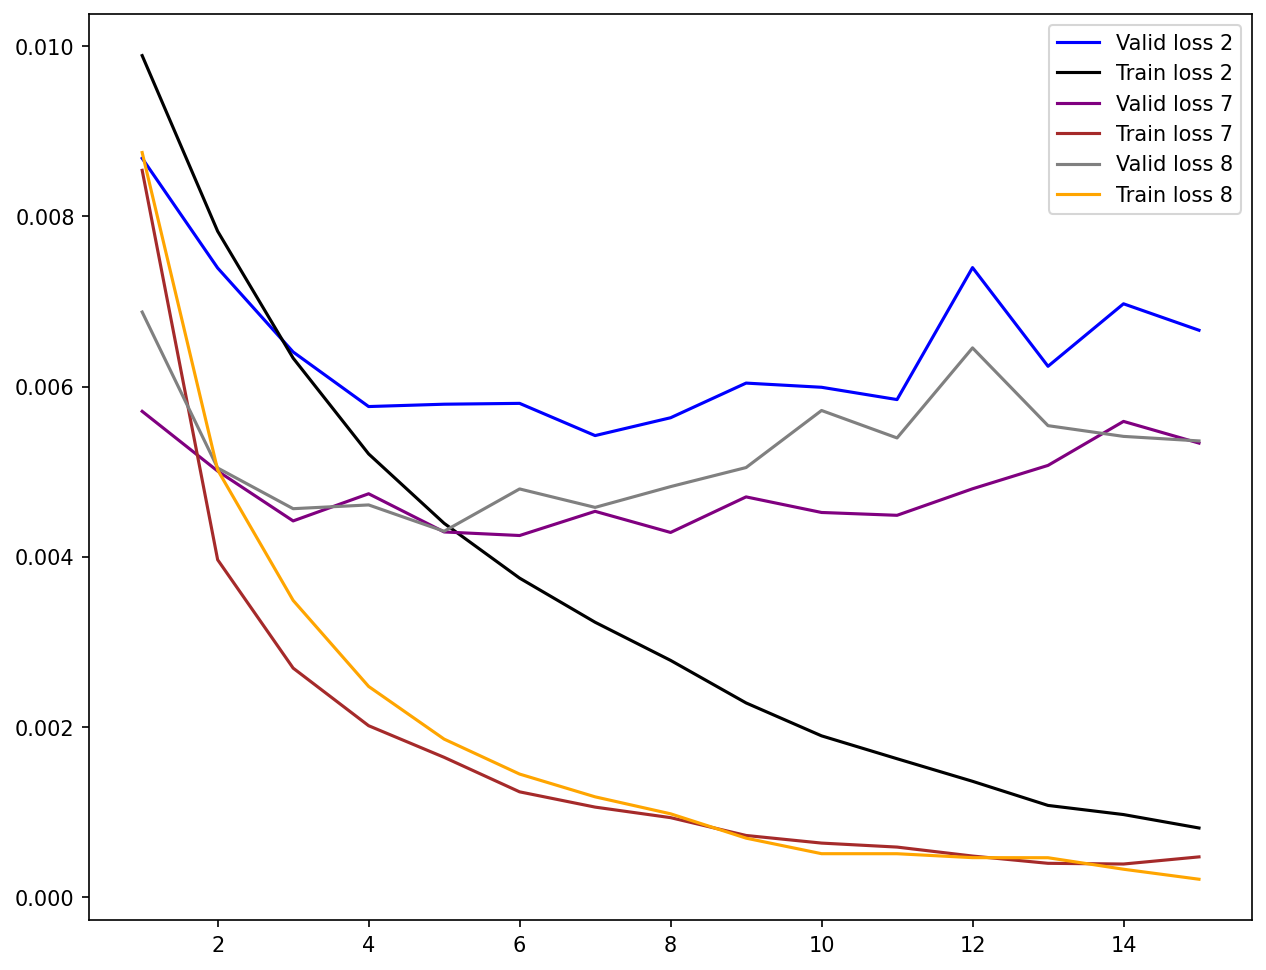

In [50]:
plt.plot(num_epoch_arr, valid_lossep2, c='blue', label="Valid loss 2")
plt.plot(num_epoch_arr, train_lossep2, c='black', label="Train loss 2")
plt.plot(num_epoch_arr, valid_lossep7, c='purple', label="Valid loss 7")
plt.plot(num_epoch_arr, train_lossep7, c='brown', label="Train loss 7")
plt.plot(num_epoch_arr, valid_lossep8, c='gray', label="Valid loss 8")
plt.plot(num_epoch_arr, train_lossep8, c='orange', label="Train loss 8")
plt.legend()
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.dpi"] = 150
plt.show()
#plot between models 2,7,8

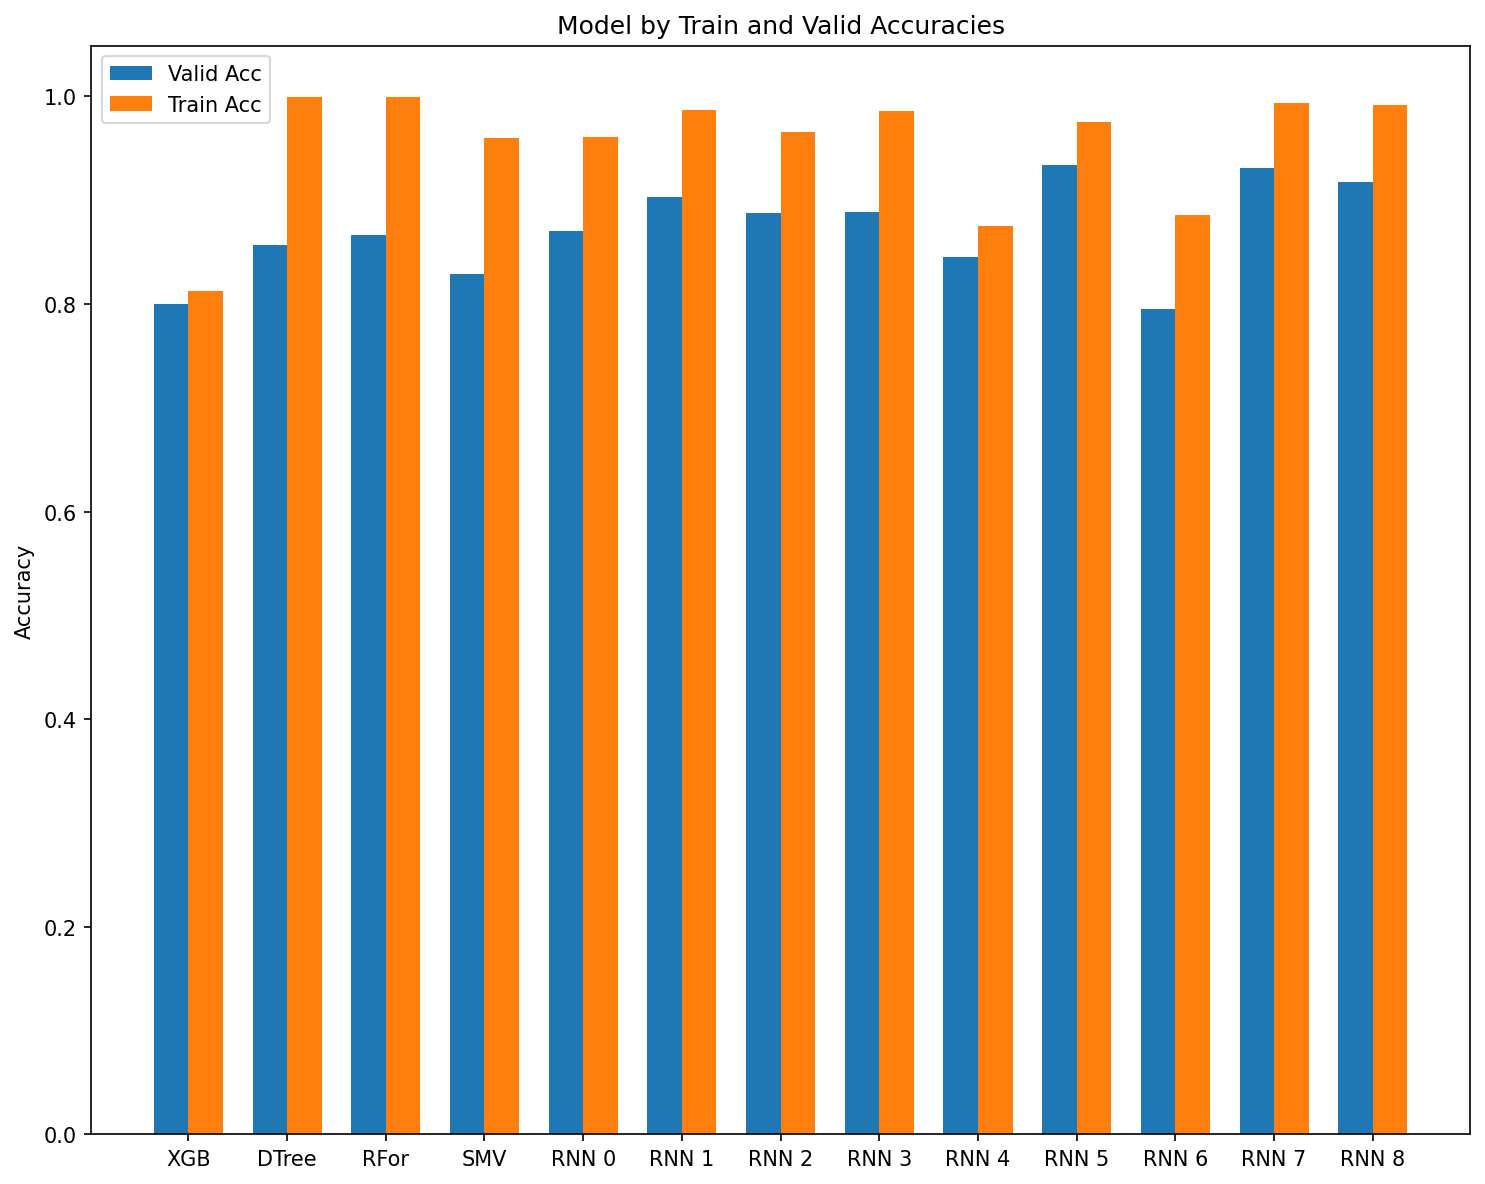

In [51]:
ModelsUsed = ['XGB', 'DTree', 'RFor', 'SMV', 'RNN 0', 'RNN 1', 'RNN 2', 'RNN 3', 'RNN 4', 'RNN 5', 'RNN 6', 'RNN 7', 'RNN 8']
num_Models = np.arange(len(ModelsUsed))
width = 0.35  
fig, accCmp = plt.subplots()
accCmp.bar(num_Models - width/2, best_valid_acc_mo, width, label='Valid Acc')
accCmp.bar(num_Models + width/2, best_train_acc_mo, width, label='Train Acc')
accCmp.set_ylabel('Accuracy')
accCmp.set_title('Model by Train and Valid Accuracies')
accCmp.set_xticks(num_Models)
accCmp.set_xticklabels(ModelsUsed)
accCmp.legend()
fig.tight_layout()
plt.show()
#plots accuracies against model